# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved


In [13]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [14]:
positions.to_excel('Positions.xlsx')

In [15]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [16]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [17]:
historical_ptf=pd.DataFrame()

In [18]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

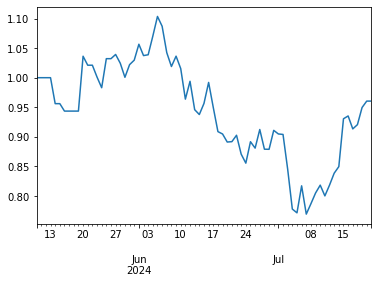

In [19]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [20]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [21]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [22]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RNDRUSDT', 'RUNEUSDT',
       'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT',
       'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT',
       'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [23]:
np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

(12, 20, 51)

## Optimal Portfolio

In [24]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[12]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[21]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[52]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.400000
OMUSDT,0.377096
BNBUSDT,0.078243
PEPEUSDT,0.077668
JASMYUSDT,0.066993


In [25]:
np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

(0, 4, 3)

In [26]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.40}])#,
                                                           #{'type': 'ineq', 'fun': lambda weights: weights[3]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[4]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.554457
BTCUSDT,0.400000
JASMYUSDT,0.045543


## Real Portfolio vs Optimal

In [27]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,714.694132,3.197201e-01,0.400000,-0.080280
JASMYUSDT,375.727526,1.680826e-01,0.045543,0.122540
OMUSDT,276.204047,1.235605e-01,0.554457,-0.430896
SOLUSDT,254.113292,1.136782e-01,0.000000,0.000000
ETHUSDT,242.826992,1.086292e-01,0.000000,0.000000
BBUSDT,162.782426,7.282110e-02,0.000000,0.000000
MKRUSDT,127.602120,5.708311e-02,0.000000,0.000000
BNBUSDT,60.427188,2.703224e-02,0.000000,0.000000
TRXUSDT,20.996794,9.392965e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.302332e-09,0.000000,0.000000


In [28]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,714.694132,3.197201e-01,0.400000,-0.080280
JASMYUSDT,375.727526,1.680826e-01,0.066993,0.101090
OMUSDT,276.204047,1.235605e-01,0.377096,-0.253535
SOLUSDT,254.113292,1.136782e-01,0.000000,0.000000
ETHUSDT,242.826992,1.086292e-01,0.000000,0.000000
BBUSDT,162.782426,7.282110e-02,0.000000,0.000000
MKRUSDT,127.602120,5.708311e-02,0.000000,0.000000
BNBUSDT,60.427188,2.703224e-02,0.078243,-0.051211
TRXUSDT,20.996794,9.392965e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.302332e-09,0.077668,-0.077668


## Risk Reward Analysis

<AxesSubplot:>

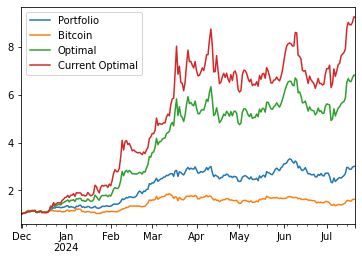

In [29]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [30]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

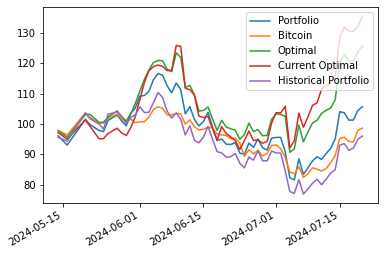

In [31]:
((1+portfolio_perf.loc[positions.index]).cumprod()*100).plot()

In [32]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.68046
dtype: float64

In [33]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.570328
dtype: float64

In [34]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.517211
Bitcoin                 0.438623
Optimal                 0.681853
Current Optimal         0.843010
Historical Portfolio    0.506828
dtype: float64

In [35]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.010646,0.016953,0.026182,0.003377,0.022804
BTCUSDT,0.025666,0.060591,0.176655,0.066210,0.110445
JASMYUSDT,0.016151,0.020895,0.048236,0.012866,0.035370
OMUSDT,0.916797,0.866443,0.670244,0.568506,0.101738
PEPEUSDT,0.030740,0.035119,0.078683,0.024548,0.054135


In [36]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.086512,0.287172,0.180910,0.044015,0.136895
JASMYUSDT,0.368282,0.197878,0.279461,0.112880,0.166580
OMUSDT,0.491740,0.172265,0.131491,0.038637,0.092854
SOLUSDT,0.068573,0.104175,0.109887,0.017593,0.092294
ETHUSDT,0.099381,0.108507,0.079119,0.009576,0.069543
BBUSDT,-0.111594,0.044468,0.146162,0.043882,0.102280
MKRUSDT,-0.002280,0.051244,0.052287,0.005215,0.047072
BNBUSDT,-0.004376,0.025167,0.019170,0.000605,0.018566
TRXUSDT,0.003763,0.009123,0.001513,0.000016,0.001496


## Value At Risk

### Historical

In [37]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05670231332410995, -0.08222837372913196)

In [38]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04899320510684464, -0.06827382530365235)

### Parametric

In [39]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0706509113922123, -0.09055493450966709)

In [40]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05909516807156755, -0.07574366655867994)

### Multivariate

In [41]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060774940247036995, -0.08113640183643289)

In [42]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.055396072536741774, -0.07147019888889486)

### Copulas

In [43]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06180872120923154, -0.08012867489793096)

In [44]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.056615449834777454, -0.07103528678673282)

In [45]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06215686729544979, -0.0799129914851784)

In [46]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05626127665028454, -0.07233738847234467)

### Monte Carlo

In [47]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07238382336984409, -0.09037542847907792)

In [48]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060781343797173384, -0.07686934324397392)

### VaR Violation

In [49]:
var_data=rolling_var(returns_to_use,opt_weights,window=25,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-09,-0.052035,-0.095200,-0.076353,-0.007454
2024-01-10,-0.052035,-0.095154,-0.078681,0.015252
2024-01-11,-0.052035,-0.094161,-0.077745,0.000798
2024-01-12,-0.058281,-0.100916,-0.084564,-0.060241
2024-01-13,-0.058281,-0.100810,-0.087454,0.009805
...,...,...,...,...
2024-07-17,-0.101639,-0.101634,-0.094317,-0.015791
2024-07-18,-0.101639,-0.099954,-0.090965,-0.002255
2024-07-19,-0.101639,-0.100168,-0.090764,0.025513
2024-07-20,-0.101639,-0.099265,-0.091246,0.015885


In [50]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.037834,-0.093621,-0.082942,-0.018802
2024-05-29,-0.031447,-0.089958,-0.078208,-0.015970
2024-05-30,-0.031447,-0.080061,-0.071334,0.041068
2024-05-31,-0.028381,-0.075829,-0.063279,0.017784
2024-06-01,-0.028381,-0.076459,-0.063940,0.036677
2024-06-02,-0.028381,-0.076709,-0.065172,0.001977
2024-06-03,-0.019697,-0.071924,-0.057770,0.012816
2024-06-04,-0.019697,-0.054830,-0.042919,0.034518
2024-06-05,-0.019697,-0.051991,-0.037777,0.017436
2024-06-06,-0.019697,-0.051922,-0.040361,-0.004706


<AxesSubplot:>

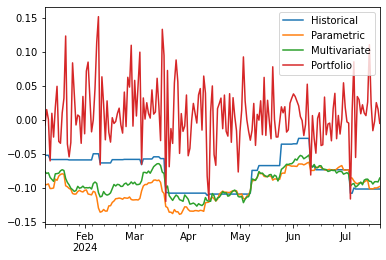

In [51]:
var_data.plot()

<AxesSubplot:>

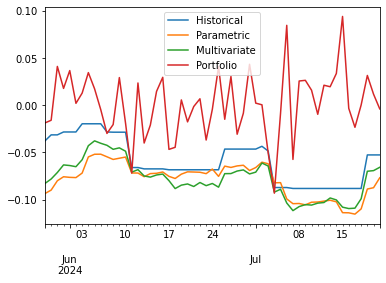

In [52]:
current_var_data.plot()

In [53]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.030769,0.010256,0.015385
Kupiec Stat,1.74931,9.483315,6.671087
P-value,0.185963,0.002073,0.009799


In [54]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.072727,0.036364,0.036364
Kupiec Stat,0.527693,0.236899,0.236899
P-value,0.467578,0.626454,0.626454


## Principal Component Analysis

In [55]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75844402, 0.07446338, 0.06229868, 0.05608759, 0.04870633])

In [56]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61151474, 0.17011886, 0.09545826, 0.07869622, 0.04421192])

In [57]:
"""faire contrib a la var de chaques modeles"""

'faire contrib a la var de chaques modeles'

In [58]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

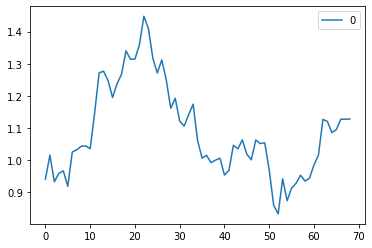

In [59]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

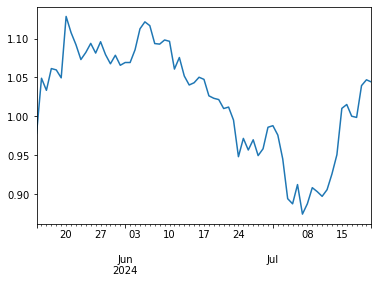

In [60]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()